In [ ]:
%%writefile -a requirements.txt
tensorflow==2.1.0
tensorflow-hub==0.8.0
matplotlib==3.3.1
numpy==1.19.1
mlflow==1.11.0
seaborn==0.11.0

Writing requirements.txt


In [ ]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 421.8MB 43kB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 11.6MB 55.4MB/s 
     |████████████████████████████████| 14.5MB 238kB/s 
     |████████████████████████████████| 13.9MB 237kB/s 
     |████████████████████████████████| 3.9MB 46.2MB/s 
     |████████████████████████████████| 450kB 53.9MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
     |████████████████████████████████| 327kB 56.6MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 6.0MB 48.0MB/s 
     |████████████████████████████████| 153kB 56.5MB/s 
     |████████████████████████████████| 163kB 64.7MB/s 
     |████████████████████████████████| 81kB 14.0MB/s 
     |████████████████████████████████| 122kB 64.6MB/s 
     |████████████████████████████████| 2.6MB 50.5MB

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import mlflow 
import argparse
import os 
import time

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.1.0
Hub version: 0.8.0
GPU is available


In [ ]:
#config

NGROK_URL='https://5f4bdb595dda.ngrok.io'
EXPERIMENT='fruit_store'
EPOCHS=5
VERSION=1

loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)

SAVE_PATH='saved_model'
%mkdir saved_model

In [ ]:
IMAGE_SIZE=[224,224]

In [ ]:
#Kaggle API
!pip3 install kaggle

!echo '{"username":"riolaface","key":"7d0c8fac857a00875fdb3296f70c9e75"}' > kaggle.json
%cat kaggle.json
%mkdir -p /root/.kaggle/
%mv kaggle.json /root/.kaggle/kaggle.json

{"username":"riolaface","key":"7d0c8fac857a00875fdb3296f70c9e75"}


In [ ]:
!kaggle datasets download  moltean/fruits

 99% 755M/760M [00:06<00:00, 119MB/s] 
100% 760M/760M [00:06<00:00, 127MB/s]


In [ ]:
!unzip fruits.zip
%rm fruit.zip

In [ ]:
train_root = "fruits-360/Training"
test_root = "fruits-360/Test"

In [ ]:
#create a custom callback to visualize the training progress during every epoch.
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])

In [ ]:
#Train code
train_generator = ImageDataGenerator(rescale=1/255) 
test_generator = ImageDataGenerator(rescale=1/255) 

train_image_data = train_generator.flow_from_directory(str(train_root),target_size=(224,224))
test_image_data = test_generator.flow_from_directory(str(test_root), target_size=(224,224))

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
feature_extractor_url = r"https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

shape:  (224, 224, 3)


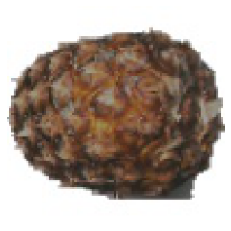

In [ ]:
x, y = next(test_image_data)
image = x[0, :, :, :]
print('shape: ', image.shape)
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                   input_shape=IMAGE_SIZE+[3], 
                                   trainable=True, arguments=dict(batch_norm_momentum=0.997))

In [ ]:
model = Sequential([
        feature_extractor_layer,
        layers.Dense(train_image_data.num_classes, activation = "softmax")
        ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 131)               167811    
Total params: 2,425,795
Trainable params: 2,391,683
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(
        optimizer = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
        loss = loss,
        metrics = ['accuracy']
        )

In [ ]:
#Mlflow settings

#set MLflow server 
mlflow.set_tracking_uri(NGROK_URL)
#Set experiment
if mlflow.get_experiment_by_name(EXPERIMENT) != None:
    exp_id = mlflow.set_experiment(EXPERIMENT)
else: 
    exp_id = mlflow.create_experiment(EXPERIMENT)

#Close active runs
if mlflow.active_run():
    mlflow.end_run()

In [ ]:
#without MLflow

steps_per_epoch = train_image_data.samples // train_image_data.batch_size
validation_steps = test_image_data.samples // test_image_data.batch_size

hist = model.fit(
    train_image_data,
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=test_image_data,
    validation_steps=validation_steps).history

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 2115 steps, validate for 709 steps
Epoch 1/5
2115/2115 [==============================] - 478s 226ms/step - loss: 4.2341 - accuracy: 0.8229 - val_loss: 4.1705 - val_accuracy: 0.8926
Epoch 2/5
2115/2115 [==============================] - 484s 229ms/step - loss: 4.1334 - accuracy: 0.9313 - val_loss: 4.1255 - val_accuracy: 0.9391
Epoch 3/5
2115/2115 [==============================] - 484s 229ms/step - loss: 4.1086 - accuracy: 0.9563 - val_loss: 4.1107 - val_accuracy: 0.9551
Epoch 4/5
2115/2115 [==============================] - 484s 229ms/step - loss: 4.0956 - accuracy: 0.9697 - val_loss: 4.0903 - val_accuracy: 0.9791
Epoch 5/5
2115/2115 [==============================] - 484s 229ms/step - loss: 4.0744 - accuracy: 0.9926 - val_loss: 4.0838 - val_accuracy: 0.9828


In [ ]:
tf.saved_model.save(model, SAVE_PATH) #SavedModel format

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
hist

{'accuracy': [0.8229234, 0.931274, 0.95626664, 0.96970147, 0.9926249],
 'loss': [4.234128261902189,
  4.133429305031213,
  4.108627452139949,
  4.095601710066653,
  4.0743575950857105],
 'val_accuracy': [0.89263046, 0.93913084, 0.95513046, 0.9791079, 0.9827662],
 'val_loss': [4.1705486710552435,
  4.125538914092673,
  4.110677901376958,
  4.090279610772395,
  4.083796587918474]}

In [ ]:
with mlflow.start_run(run_id=None, experiment_id=exp_id, run_name=None, nested=False): 
      
      steps_per_epoch = train_image_data.samples # train_generator.batch_size
      validation_steps = test_image_data.samples # valid_generator.batch_size

      # fitting the model
      hist = model.fit(
        train_image_data,
        epochs=EPOCHS, 
        steps_per_epoch=steps_per_epoch,
        validation_data=test_image_data,
        validation_steps=validation_steps).history

      #mlflow autolog
      #mlflow.tensorflow.autolog()

      #Set tags
      tags={}
      tags['name']=EXPERIMENT
      tags['version']=VERSION
      mlflow.set_tags(tags)

      #mlflow logging
      
      # log parameters
      mlflow.log_param("epochs", EPOCHS)
      mlflow.log_param("loss_function", str(loss))

      # log metrics
      for epoch in range(0, EPOCHS):
        mlflow.log_metric("accuracy", hist['accuracy'][epoch])
        mlflow.log_metric("loss",  hist['loss'][epoch])
        mlflow.log_metric("val_accuracy",  hist['val_accuracy'][epoch])
        mlflow.log_metric("val_loss",  hist['val_loss'][epoch])
      
      #results=evaluate_model() #TODO
      #mlflow.log_metric("average_loss", results[0])
      #mlflow.log_metric("average_acc", results[1])
      
      #log model
      #model.save(os.path.join(BASE_DIR, "models", "{}.h5".format(int(t)))) #HDF5 format
      tf.saved_model.save(model, SAVE_PATH) #SavedModel format
      #mlflow.tensorflow.log_model(model, 'model') #TODO fix
      
      # log artifacts (matplotlib images for loss/accuracy)
      #mlflow.log_artifacts(model_folder)

      mlflow.end_run()

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in test_image_data.class_indices.items():
      if class_index == index:
         return class_string

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


True label: Pineapple
Predicted label: Pineapple


In [ ]:
optimize_lite_model = True  
num_calibration_examples = 60  
representative_dataset = None

In [ ]:
#Converting without optimization provides the same results as before (up to roundoff error).
#Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
#On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_image_data for image in batch),
      num_calibration_examples)

In [ ]:
import itertools

converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_PATH)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
num_eval_examples = 50  
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_image_data
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))